### Load required libraries

In [26]:
import os
import urllib, cStringIO

import pymongo as pm

import matplotlib
from matplotlib import pylab, mlab, pyplot
%matplotlib inline
from IPython.core.pylabtools import figsize, getfigs
plt = pyplot
# import seaborn as sns
# sns.set_context('poster')
# sns.set_style('white')

import numpy as np
from __future__ import division
import scipy.stats as stats

import pandas as pd
import json
import re

from PIL import Image
import base64

import seaborn as sns
from glob import glob

from scipy.spatial import distance

### Load VGG feature analysis libraries and scripts

In [27]:
import torch
import torchvision.models as models
import torch.nn as nn
import torchvision.transforms as transforms
import torch.nn.functional as F
from torch.autograd import Variable

import scipy.stats as stats
from scipy.stats import norm
# import sklearn
# from sklearn.model_selection import train_test_split, cross_val_score
# from sklearn import svm
# from sklearn import linear_model, datasets, neighbors

from sklearn.cluster import AffinityPropagation
# from sklearn import metrics

from glob import glob
import os

import embedding as emb
reload(emb)
from embedding import *

In [30]:
# Retrieve sketch paths -- pngs rendered out in another step
def list_files(path, ext='png'):
    result = [y for x in os.walk(path) for y in glob(os.path.join(x[0], '*.%s' % ext))]
    return result

# extract metadata
path_to_sketches = 'museumstation_sketches'
sketch_paths = sorted(list_files(path_to_sketches))

## number of sketch paths 
print 'Number of sketch paths = {} before filtering'.format(len(sketch_paths))
png_sketch_count = len(sketch_paths)

Number of sketch paths = 8037 before filtering


## extract features

**Dec 28 2017 (updated Jan 14 2018):** <br>
 - From command line, extract features using `extract_features.py`. The default arguments are for the kid's drawings. <br>
 - To extract kid's drawings, just run: `python extract_features.py` <br>
 - To extract (mini verison of) adult drawings, run: `python extract_features.py --data='/data2/jefan/quickDraw/png_mini' --layer_ind=6 --cohort='adult' --spatial_avg=True`

In [31]:
# z-score normalization to "center" the sketch embeddings
def normalize(X):
    X = X - X.mean(0)
    X = X / np.maximum(X.std(0), 1e-5)
    return X

def get_class_means(X, labels):    
    # load in and normalize features 
    _mu = np.zeros((len(np.unique(labels)), np.shape(X)[1]))        
    X = normalize(X)
    for vi, v in enumerate(np.unique(np.asarray(labels))):
        Xv = X[labels == v]
        nv = float(Xv.shape[0])
        if nv > 0:
            _mu[vi] = Xv.mean(0)
    return _mu

def get_class_means_not_normalized(X, labels):    
    # load in and normalize features 
    _mu = np.zeros((len(np.unique(labels)), np.shape(X)[1]))        
    for vi, v in enumerate(np.unique(np.asarray(labels))):
        Xv = X[labels == v]
        nv = float(Xv.shape[0])
        if nv > 0:
            _mu[vi] = Xv.mean(0)
    return _mu

def normalize_RDM(MAT):
    X = MAT - MAT.mean(0).mean(0)
    X = X / np.maximum(MAT.std(0).std(0), 1e-5)
    return X

def plot_rdm_by_class(Features,X,layer_num):
    layers = ['P1','P2','P3','P4','P5','FC6','FC7']        
    sns.set_style('white')
    fig = plt.figure(figsize=(6,6))
    labels = X.label.values
    means = get_class_means(Features, labels)
    CORRMAT = np.corrcoef(means)
    plt.matshow(CORRMAT)
    plt.colorbar()
    if not os.path.exists('./plots'):
        os.makedirs('./plots')
    plt.savefig('./plots/RDM_by_view_{}.pdf'.format(layers[layer_num]))
    
def load_features(cohort, layer_num):
    layers = ['P1','P2','P3','P4','P5','FC6','FC7']    
    F = np.load('museumstation_features/FEATURES_{}_{}_Spatial_True.npy'.format(layers[layer_num],cohort))
    M = pd.read_csv('museumstation_features/METADATA_{}.csv'.format(cohort)) 
#     F = np.load('/data/old_home/bria/kiddraw/data/museumstation_features/FEATURES_{}_{}_Spatial_True.npy'.format(layers[layer_num],cohort))
#     M = pd.read_csv('/data/old_home/bria/kiddraw/data/museumstation_features/METADATA_{}.csv'.format(cohort)) 
    
    M = M[['label','age','session']]
    return F, M

def remove_practice_trials(KF,KM):
    '''
    remove "circle" and "triangle" trials from dataset
    '''
    practice_objects = ['circle','triangle']
    _KF = KF[~KM['label'].isin(practice_objects),:]
    _KM = KM[~KM['label'].isin(practice_objects)]
    return _KF, _KM

def flatten(x):
    return [item for sublist in x for item in sublist]


In [32]:
## CHOOSE LAYER IND FOR PLOTTING RDMS ETC
layer_ind = 6

## load in kid features
KF, KM = load_features('kid',layer_ind)
KF, KM = remove_practice_trials(KF, KM)
KM = KM.reset_index(drop=True)

print 'Number of unique kids who contributed drawings = {}'.format(np.size(np.unique(KM['session'].values)))
print 'Number of features for {} images in layer {} = {}'.format(np.shape(KF)[0], layer_ind, np.shape(KF)[1])
feature_sketch_count = np.shape(KF)[0]

Number of unique kids who contributed drawings = 1447
Number of features for 7326 images in layer 6 = 4096


### Separate drawings according to the age bins

In [33]:
def finer_grain_age(row):
    if row['age'] > 7: ### 8 9 10
        val = 'oldest'
    elif row['age'] > 5: # 6 7
        val = 'older'
    elif row['age'] > 3: # 4 5
        val = 'younger'
    elif row['age'] <= 3: # 2 3
        val = 'youngest' 
    return val
    
KM['finer_age'] = KM.apply(finer_grain_age, axis=1)

In [34]:
ind = KM.index[KM['finer_age'] == 'oldest']
KM_oldest = KM.loc[ind]
KF_oldest = KF[ind.tolist()]

ind2 = KM.index[KM['finer_age'] == 'older']
KM_older = KM.loc[ind2]
KF_older = KF[ind2.tolist()]

ind3 = KM.index[KM['finer_age'] == 'younger']
KM_younger = KM.loc[ind3]
KF_younger = KF[ind3.tolist()]

ind4 = KM.index[KM['finer_age'] == 'youngest']
KM_youngest = KM.loc[ind4]
KF_youngest = KF[ind4.tolist()]


In [35]:
print 'We have {} drawings in the youngest cohort from {} 2-3 year olds'.format(np.shape(KF_youngest)[0],np.shape(np.unique(KM_youngest['session']))[0])
print 'We have {} drawings in the younger cohort from {} 4-5 year olds'.format(np.shape(KF_younger)[0],np.shape(np.unique(KM_younger['session']))[0])
print 'We have {} drawings in the older cohort from {} 6-7 year olds'.format(np.shape(KF_older)[0],np.shape(np.unique(KM_older['session']))[0])
print 'We have {} drawings in the oldest cohort from {} 8-10 year olds'.format(np.shape(KF_oldest)[0],np.shape(np.unique(KM_oldest['session']))[0])


We have 1995 drawings in the youngest cohort from 478 2-3 year olds
We have 2164 drawings in the younger cohort from 414 4-5 year olds
We have 1582 drawings in the older cohort from 274 6-7 year olds
We have 1585 drawings in the oldest cohort from 281 8-10 year olds


#### Get distribution of drawings across label and coarse age category 

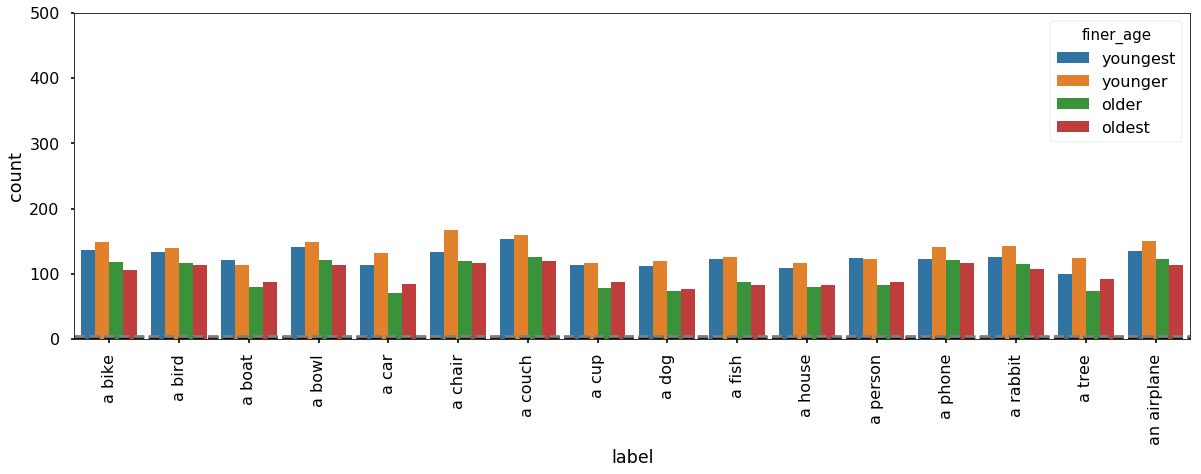

In [18]:
sns.set_context('poster')
plt.figure(figsize=(20,6))
sns.countplot(data=KM,
           x='label',
           hue='finer_age')
labels = np.unique(KM.label.values)
h = plt.xticks(range(len(labels)), labels, fontsize=16,rotation='vertical')
plt.axhline(3,linestyle='dashed',color='black')
plt.axhline(5,linestyle='dashed',color='gray')
plt.ylim(0,500)
if not os.path.exists('./plots'):
    os.makedirs('./plots')
plt.savefig('./plots/drawing_counts_by_label_and_finer_age.pdf', bbox_inches="tight")

### Representational Similarity Analyses

In [262]:
def get_and_plot_RDM(M,F,cohort,sort_inds, layer_ind):
    ## sorted adult RDMs
    labels = M.label.values
    means = get_class_means(F, labels)
    ordered_means = means[sort_inds,:]
    sns.set_style('white')
    CORRMAT = np.corrcoef(ordered_means)
    sns.set_context('paper')
    fig = plt.figure(figsize=(30,30))
    plt.matshow(1-CORRMAT, vmin=0, vmax=2)
    plt.xticks(range(len(ordered_objs)), ordered_objs, rotation=90);
    plt.yticks(range(len(ordered_objs)), ordered_objs); 
    plt.colorbar()
    for tick in pylab.gca().xaxis.iter_ticks():
        tick[0].label2On = True
        tick[0].label1On = False
        tick[0].label2.set_rotation('vertical')
        tick[0].tick1On = False
        tick[0].tick2On = False
    for tick in pylab.gca().yaxis.iter_ticks():
        tick[0].tick1On = False
        tick[0].tick2On = False  
    RDM = CORRMAT
    plt.gcf().subplots_adjust(left=0.5) 
    plt.savefig('./plots/RDM_{}_Layer_{}.pdf'.format(cohort, layer_ind), bbox_inches="tight")
    return RDM

def show_dprime(d_prime,ordered_objs,age):
    sns.set_context('paper')
    fig = plt.figure(figsize=(30,30))
    plt.matshow(d_prime, vmin=0, vmax=6)
    plt.xticks(range(len(ordered_objs)), ordered_objs, rotation=90);
    plt.yticks(range(len(ordered_objs)), ordered_objs); 
    plt.colorbar()
    for tick in pylab.gca().xaxis.iter_ticks():
        tick[0].label2On = True
        tick[0].label1On = False
        tick[0].label2.set_rotation('vertical')
        tick[0].tick1On = False
        tick[0].tick2On = False
    for tick in pylab.gca().yaxis.iter_ticks():
        tick[0].tick1On = False
        tick[0].tick2On = False 
    plt.savefig('./plots/Dprime_{}_Layer_{}.pdf'.format(age, layer_ind), bbox_inches="tight")

def showRDM(RDM,ordered_objs,age):
    sns.set_context('paper')
    fig = plt.figure(figsize=(30,30))
    plt.matshow(RDM, vmin=0, vmax=2)
    plt.xticks(range(len(ordered_objs)), ordered_objs, rotation=90);
    plt.yticks(range(len(ordered_objs)), ordered_objs); 
    plt.colorbar()
    for tick in pylab.gca().xaxis.iter_ticks():
        tick[0].label2On = True
        tick[0].label1On = False
        tick[0].label2.set_rotation('vertical')
        tick[0].tick1On = False
        tick[0].tick2On = False
    for tick in pylab.gca().yaxis.iter_ticks():
        tick[0].tick1On = False
        tick[0].tick2On = False  
    plt.savefig('./plots/RDM_{}_Layer_{}.pdf'.format(age, layer_ind), bbox_inches="tight")
    
def get_RDM(M,F,sort_inds):
    ## sorted adult RDMs
    labels = M.label.values
    means = get_class_means(F, labels)
    ordered_means = means[sort_inds,:]    
    RDM = np.corrcoef(ordered_means)
    return RDM

def get_class_variance(F,M,this_label):    
    class_features = F[M.label.values==this_label]
    class_mean = class_features.mean(0);
    num_features = np.shape(class_features)[0]
    _dist = np.zeros(num_features)  
    for vi in range(np.shape(class_features)[0]):
        _dist[vi] = distance.euclidean(class_features[vi],class_mean) ## get euclidean distance to mean
    dist_sum = sum(_dist) / vi; # sum these distances and divide by the number of items
    return np.sqrt(dist_sum) #  get square root to make it a variance

def get_class_means_bl(F, M):  # just adapted to take in features and metadata directly  
    X = F;
    labels = M.label.values
    _mu = np.zeros((len(np.unique(labels)), np.shape(X)[1]))        
     X = normalize(X) 
    for vi, v in enumerate(np.unique(np.asarray(labels))):
        Xv = X[labels == v]
        nv = float(Xv.shape[0])
        if nv > 0:
            _mu[vi] = Xv.mean(0)
    return _mu

def get_class_dprime(class_var, class_means,ordered_objs):
    d_prime = np.zeros((len(np.unique(ordered_objs)), len(np.unique(ordered_objs)))); # n-class x n-class matrix      
    for vi, v in enumerate(ordered_objs):
        for vi2, v2 in enumerate(ordered_objs):
            if vi==vi2:
                d_prime[vi,vi2] = 0; # give dummy value when looking at same category, 0 = the same category
            else:
                v1=class_var[vi]; v2=class_var[vi2]; # grab class variance for each pair of categories
                m1=class_means[vi];  m2=class_means[vi2]; # grab class means for each pair of categories
                num = distance.euclidean(m1,m2) # distance between two mean vectors
                denom = np.sqrt(.5*(v1**2+v2**2)); # calculate denominator 
                d=num/denom;
                d_prime[vi,vi2] = d;  # fill in matrix
    return d_prime;

In [390]:

# _labels = np.unique(KM.label.values)
# means = get_class_means(KF, KM.label.values)
# af = AffinityPropagation(damping=0.5).fit(means)
# labels = af.labels_
# cluster_centers_indices = af.cluster_centers_indices_
# n_clusters_ = len(cluster_centers_indices)

# ordered_objs = []
# print('Clusters')
# for k in range(n_clusters_):
#     class_members = labels == k
#     print _labels[class_members]
#     ordered_objs.append(list(_labels[class_members]))
    
# ordered_objs = np.array(flatten(ordered_objs))

# # define standard order to be used for RDM's across layers
# standard_order = ordered_objs

# ## index for sorting the alphabetical list of labels INTO the order specified by ordered_objs (clustered)
# sort_inds = [np.where(_labels==ordered_objs[i])[0][0] for i in np.arange(len(ordered_objs))]
# ordered_objs


ordered_objs = ['an airplane', 'a bike', 'a car', 'a boat', 'a chair', 'a couch', 'a house', 'a cup', 'a bowl', 'a phone', 'a person', 'a bird', 'a dog', 'a fish', 'a rabbit', 'a tree']
ordered_objs = np.asarray(ordered_objs)
sort_inds = [np.where(_labels==ordered_objs[i])[0][0] for i in np.arange(len(ordered_objs))]


In [391]:
class_list = np.asarray(np.unique(KM.label.values))
dprime_by_age = np.zeros([np.shape(class_list)[0], np.shape(class_list)[0], np.shape(range(2,11))[0]])
dprime_avg_by_age = np.zeros(np.shape(range(2,11)))


for age in range(2,11):
#     print age
    ind = KM.index[KM['age'] == age]
    KM_subset =  KM.loc[ind]
    KF_subset =  KF[ind.tolist()]
#     print np.shape(KF_subset)
    class_means = np.zeros(np.shape(class_list)[0])
    class_variance = np.zeros(np.shape(class_list)[0]) 
    class_means = get_class_means_bl(KF_subset, KM_subset)
    
    agei = age-2
    for l, this_label in enumerate(ordered_objs):
#         print this_label
        class_variance[l] = get_class_variance(KF_subset,KM_subset,this_label)
    print np.std(class_variance)
    dprime_this_age = get_class_dprime(class_variance, class_means,ordered_objs)
    dprime_by_age[:,:,agei] = dprime_this_age
    dprime_avg_by_age[agei] = np.mean(np.ravel(dprime_this_age[np.triu_indices(dim,k=1)]))

0.337499910261
0.333564315359
0.481063965222
0.456582330997
0.466109570453
0.521798303285
0.667218500679
0.584614776838
0.626745762241


In [393]:
dim = 16
for agei in range(0,9):
    this_age = dprime_by_age[:,:,agei]
    print 'average d prime of {} year old = {} '.format(agei+2, np.round(dprime_avg_by_age[agei],2))

average d prime of 2 year old = 2.41 
average d prime of 3 year old = 2.18 
average d prime of 4 year old = 2.79 
average d prime of 5 year old = 3.35 
average d prime of 6 year old = 3.5 
average d prime of 7 year old = 3.77 
average d prime of 8 year old = 3.79 
average d prime of 9 year old = 3.84 
average d prime of 10 year old = 3.71 


In [394]:
for age in range(9,1,-1):
    agei=age-2
    print ' {}-yrs, M={}'.format(age, np.round(dprime_avg_by_age[agei],2))

 9-yrs, M=3.84
 8-yrs, M=3.79
 7-yrs, M=3.77
 6-yrs, M=3.5
 5-yrs, M=3.35
 4-yrs, M=2.79
 3-yrs, M=2.18
 2-yrs, M=2.41


<Container object of 3 artists>

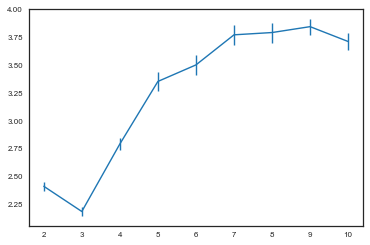

In [367]:
test = (dprime_by_age[np.triu_indices(dim,k=1)])
dprime_age_means = np.mean(test,0)
dprime_age_stds = np.std(test,0)/np.sqrt(120)

matplotlib.pyplot.errorbar(np.arange(2,11), mean_vals, yerr = dprime_age_stds )


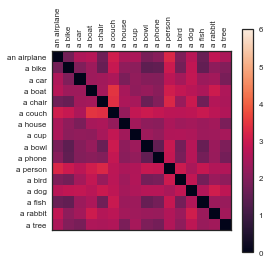

In [368]:
show_dprime(dprime_by_age[:,:,0],ordered_objs,'age2')


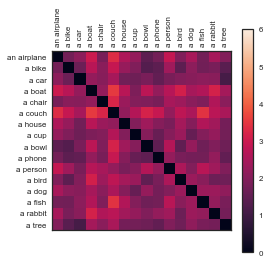

In [369]:
show_dprime(dprime_by_age[:,:,1],ordered_objs,'age3')


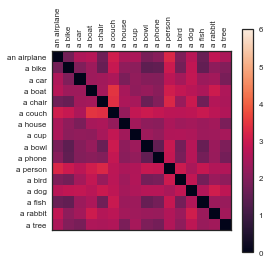

In [370]:
show_dprime(dprime_by_age[:,:,0],ordered_objs,'age2')

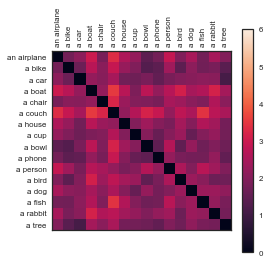

In [371]:
show_dprime(dprime_by_age[:,:,1],ordered_objs,'age3')

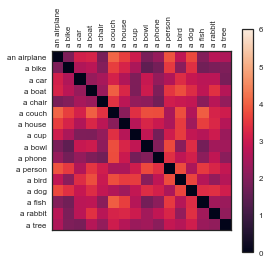

In [372]:
show_dprime(dprime_by_age[:,:,2],ordered_objs,'age4')

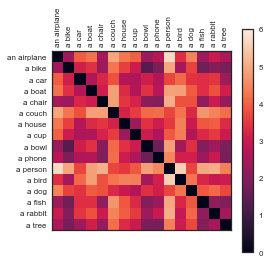

In [373]:
show_dprime(dprime_by_age[:,:,3],ordered_objs,'age5')

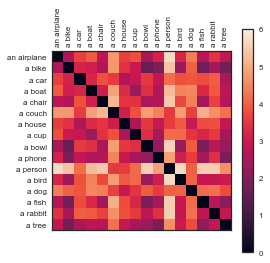

In [374]:
show_dprime(dprime_by_age[:,:,4],ordered_objs,'age6')

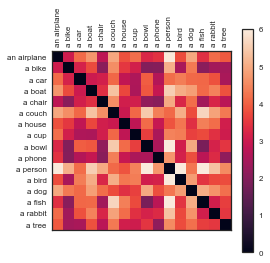

In [375]:
show_dprime(dprime_by_age[:,:,5],ordered_objs,'age7')

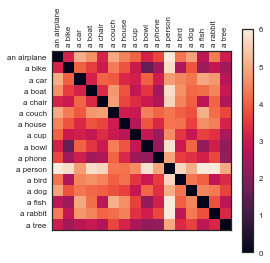

In [376]:
show_dprime(dprime_by_age[:,:,6],ordered_objs,'age8')

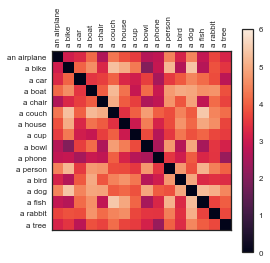

In [377]:
show_dprime(dprime_by_age[:,:,7],ordered_objs,'age9')

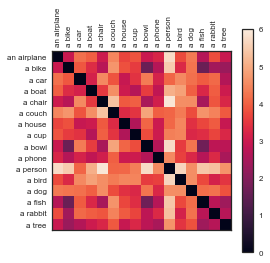

In [378]:
show_dprime(dprime_by_age[:,:,8],ordered_objs,'age10')

In [380]:
rdm_by_age = np.zeros([np.shape(class_list)[0], np.shape(class_list)[0], np.shape(range(2,11))[0]])
rdm_corr_age = np.zeros(np.shape(range(10,2,-1))[0])

for age in range(2,11):
    agei = age-2
    ind = KM.index[KM['age'] == age]
    KM_subset =  KM.loc[ind]
    KF_subset =  KF[ind.tolist()]

    class_means = np.zeros(np.shape(class_list)[0])
    class_means = get_class_means_bl(KF_subset, KM_subset)
    ordered_means = class_means[sort_inds,:]
    this_rdm = np.corrcoef(ordered_means)
    this_rdm = 1 - this_rdm
    if age==10:
        oldest_rdm = this_rdm
    else:
        rdm_by_age[:,:,agei] = this_rdm
        rdm_corr_age[agei] = stats.spearmanr(np.ravel(oldest_rdm[np.triu_indices(16,k=1)]),np.ravel(this_rdm[np.triu_indices(16,k=1)]))[0]
        print 'rdm corr for age {} is {}'.format(age, rdm_corr_age[agei])

rdm corr for age 2 is 0.755274671852
rdm corr for age 3 is 0.852934231544
rdm corr for age 4 is 0.843829432599
rdm corr for age 5 is 0.934009306202
rdm corr for age 6 is 0.920341690395
rdm corr for age 7 is 0.913125911522
rdm corr for age 8 is 0.924328078339
rdm corr for age 9 is 0.913077297035


In [381]:
for age in range(9,1,-1):
    agei=age-2
    print ' {}-yrs, M={}'.format(age, np.round(rdm_corr_age[agei],2))

 9-yrs, M=0.91
 8-yrs, M=0.92
 7-yrs, M=0.91
 6-yrs, M=0.92
 5-yrs, M=0.93
 4-yrs, M=0.84
 3-yrs, M=0.85
 2-yrs, M=0.76


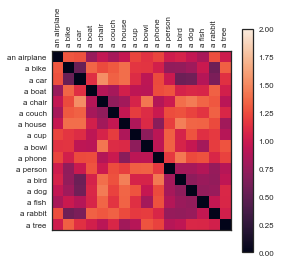

In [382]:
showRDM(rdm_by_age[:,:,0],ordered_objs,'age2')


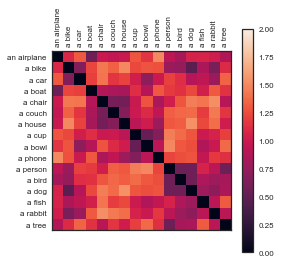

In [383]:
showRDM(rdm_by_age[:,:,1],ordered_objs,'age3')

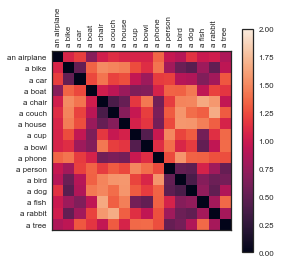

In [384]:
showRDM(rdm_by_age[:,:,2],ordered_objs,'age4')

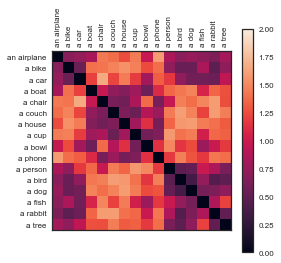

In [385]:
showRDM(rdm_by_age[:,:,3],ordered_objs,'age5')


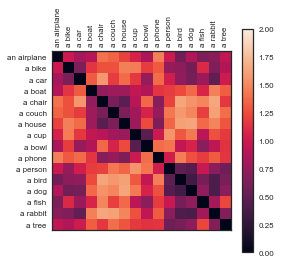

In [386]:
showRDM(rdm_by_age[:,:,4],ordered_objs,'age6')


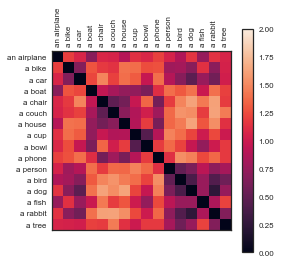

In [387]:
showRDM(rdm_by_age[:,:,5],ordered_objs,'age7')


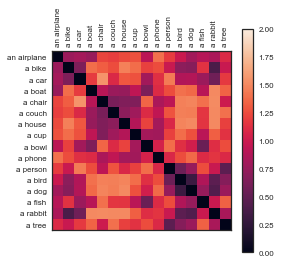

In [388]:
showRDM(rdm_by_age[:,:,6],ordered_objs,'age8')


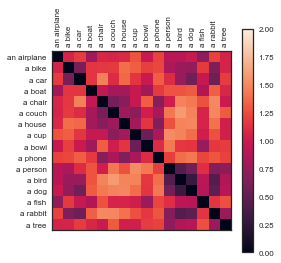

In [389]:
showRDM(rdm_by_age[:,:,7],ordered_objs,'age9')
